# MATH80629
# Semaine \#6 (Partie II) - Réseaux à Convolution - Exercices

Auteur: *Behrouz Babaki*

Ce tutoriel explore les opérations de convolution et de pooling qui sont à la base des réseaux de neurones à convolution. 


# Convolution

Dans le cours, nous avons introduit des filtres (kernel) comme étant des matrices qui peuvent être déplacés sur les différentes régions de l'imagine en prenant à chaque fois un produit scalaire. Pour illustrer le concept de convolution, nous allons utiliser une petite image et un filtre. 

### L'image. 

Prenons un exemple avec cette petite image de 3 rangées par 3 colonnes:

<img src="images/tiny.svg" width="150" />

L'ordinateur voit cette image comme une matrice de pixel, où chaque pixel à une valeur entre 0 et 255&nbsp;:

<img src="images/grid1.svg" width="150" />

La valeur du chiffre est donc le niveau de gris. De 0 pour un pixel noir à 255 pour un pixel blanc. 


### Le filtre.

Nous allons utiliser un filtre *moyenne mobile* (moving average). 

Un filtre moyenne mobile de taille $k$ est une matrice de $k \times k$ où toutes les valeurs sont de $1/k^2$. 

Par exemple, pour $k=2$ on obtient le filtre suivant&nbsp;:

<img src="images/filter1.svg" width="100" />

Comme expliqué dans le cours, pour faire une convolution entre un filtre et une image, on *déplace* le filtre sur toute l'image et à chaque emplacement on calcule le produit scalaire entre les valeurs du filtre et celles des pixels de l'image. 

L'animation suivante vous montre la convolution entre un filtre de $3 \times 3$ (bleu foncé se déplaçant), une image de $4 \times 4$ (bleu pâle en bas) et le résultat de l'opération (vert foncé en haut). 

<p>
<figure>
    <img src="images/slide_nostride_nopadding.gif" width="250"/>
    <figcaption style="text-align:center;font: italic small sans-serif"> Source: <a href="http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html#no-zero-padding-unit-strides">Theano documentation</a> </figcaption>
</figure>
<br>
</p>

Le résultat de cette convolution est donc une matrice de taille $2 \times 2$. 

Calculons les valeurs exactes de la convolution. Si on applique le filtre sur le coin en haut à gauche de l'image, nous obtenons&nbsp;: 
$(20, 213, 60, 83)\cdot(0.25, 0.25, 0.25, 0.25) = 94$:

<img src="images/apply1.svg" width="450"/>


### Question 1
Veuillez calculer les valeurs des trois sorties de la convolution.  



## Appliquer des filtres à de véritables images

Nous allong maintenant étudier l'effet de deux filtres sur une image de Charlie Chaplin.

--2021-10-05 23:26:45--  https://raw.githubusercontent.com/lcharlin/80-629/master/week6-RNNs%2BCNNs/images/Charlie_Chaplin.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1071227 (1.0M) [image/jpeg]
Saving to: ‘Charlie_Chaplin.jpg’

Charlie_Chaplin.jpg 100%[===================>]   1.02M  3.20MB/s    in 0.3s    

2021-10-05 23:26:46 (3.20 MB/s) - ‘Charlie_Chaplin.jpg’ saved [1071227/1071227]



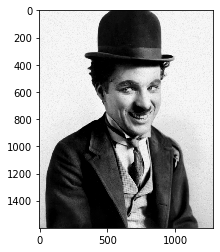

In [1]:
import matplotlib
from matplotlib import pyplot as plt

!wget https://raw.githubusercontent.com/lcharlin/80-629/master/week6-RNNs%2BCNNs/images/Charlie_Chaplin.jpg
image = matplotlib.image.imread('Charlie_Chaplin.jpg').astype('int')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

### Filtre Moyenne mobile

Nous utilisons pour commencer un filtre *moyenne mobile* de taille $k=30$. 

Avant d'aller voir la réponse, essayer de déterminer l'effet sur l'image de ce filtre. 

*Indice:* chaque pixel sera donc remplacé par la moyenne du pixel et de trente de ces voisins.

&nbsp;

&nbsp;


&nbsp;


&nbsp;

&nbsp;

&nbsp;

&nbsp;


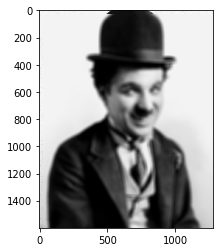

In [4]:
img_blurred = image.copy()
n_rows, n_cols = image.shape

k = 30
for r in range(k, n_rows):
    for c in range(k, n_cols):
        img_blurred[r, c] = image[r-k:r,c-k:c].sum() / (k**2)
        
plt.imshow(img_blurred, cmap='gray', vmin=0, vmax=255)

### Question #2
1. Quel est l'effet du filtre *moyenne mobile*?
2. Quel est l'effet de changer la valeur de $k$? Par exemple, essayez $k=10$. 
3. A quoi sert cette ligne dans la fonction de convolution?  `img_blurred[r, c] = img[r-k:r,c-k:c].sum() / (k**2)`



### Filtre pour détection des contours

Comme discuté dans le cours, un filtre pour détecter les contours (*edge detection*) peut prendre la forme $(-1, 1)$ ou $(1, -1)$. Nous allons utiliser ce filtre sur notre image de Charlie Chaplin. 

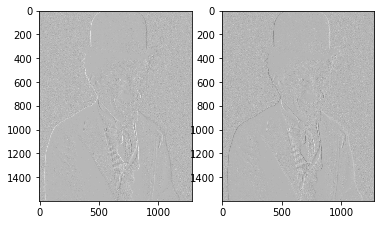

In [10]:
image_edges_1 = image.copy()
image_edges_2 = image.copy()
n_rows, n_cols = image.shape
for r in range(1, n_rows):
    for c in range(1, n_cols):
        image_edges_1[r,c] = image[r,c] - image[r,c-1]
        image_edges_2[r,c] = -image[r,c] + image[r,c-1]
        
plt.subplot(1, 2, 1)
plt.imshow(255-image_edges_1, cmap='gray') # on ajoute "255 -" simplement
                                           # pour mieux voir le résultat
plt.subplot(1, 2, 2)
plt.imshow(255-image_edges_2, cmap='gray');

# Réseaux à convolution

L'opération principale des réseaux à convolution est... la convolution! Une couche de convolution contient des filtres qui seront appris par le réseau. 

Précédemment, nous avons vu comment un filtre (fixe) est appliqué à une image. 

Nous allons maintenant voir l'effet des hyperparamètres reliés aux convolutions. Le premier hyperparamètre est celui du pas (*Stride*).

## Pas (Stride)

L'hyperparamètre *pas* contrôle comment la taille du déplacement du filtre sur l'image. Avec un pas à 1, le filtre se déplace d'un pixel à la fois dans chaque dimension. Avec un pas de 2, le filtre se déplace de deux pixels à la fois&nbsp;: 

<p>
<figure>
    <img src="images/slide_stride2_nopadding.gif" width="250"/>
    <figcaption style="text-align:center;font: italic small sans-serif"> image source: <a href="http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html#no-zero-padding-non-unit-strides">Theano documentation</a> </figcaption>
</figure>
<br>
</p>


## Couche MAX-Pooling

Rappelez-vous que la couche de max-pooling réduit la dimensionnalité de son entrée en remplaçant un ensemble de pixels voisins par un seul pixel ayant leur valeur maximale. Comme pour les convolutions, on peut appliquer le pooling avec un pas&nbsp;:

<img src="images/maxpooling.svg" width="550"/>

Plus le pas est grand et plus importante sera la réduction de la dimensionnalité. 

## Question #3

Pour cet exercice, vous appliquerez manuellement les couches de convolution et de « pooling » sur deux images. La figure ci-dessous vous montre l'ordre des opérations&nbsp;:

<img src="images/exercise.svg" width="650"/>

Les filtres (kernels) sont des matrices de $3 \times 3$&nbsp;: 
```
kernel1 = [[0, 0, 0], 
           [1, 1, 1], 
           [0, 0, 0]]

kernel2 = [[1, 0, 0], 
           [0, 1, 0], 
           [0, 0, 1]]
```

<img src="images/kernels.svg" width="250"/>

Les deux images sont:
```
image1 = [[0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1],
          [0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1],
          [0, 0, 0, 0, 0]]

image2 = [[1, 0, 0, 1, 0],
          [0, 1, 0, 0, 1],
          [0, 0, 1, 0, 0],
          [1, 0, 0, 1, 0],
          [0, 1, 0, 0, 1]]
```

<img src="images/input_images.svg" width="350"/>

1. Pour chaque image, calculez la sortie des couches de convolution et de max-pooling. Attention à la taille des pas (*stride*) dans la couche de convolution. 
2. Qu'est-ce que détectent ces deux filtres?
3. Si vous utilisiez ces couches dans un réseau à convolution, combien y aurait-il de paramètres à appendre? 

<!-- 4. This pipeline is different from a convolutional neural network, i.e. it misses a few components. Name those differences. --> 
